In [36]:
import condorgmm
import condorgmm.data
import matplotlib.pyplot as plt
import condorgmm.warp_gmm as warp_gmm
import warp as wp

In [38]:
import rerun as rr
import numpy as np
import importlib
condorgmm.rr_init("intro")

importlib.reload(condorgmm.utils.common.rerun)
importlib.reload(condorgmm.utils.common)
importlib.reload(condorgmm.utils)
importlib.reload(condorgmm)

rr.log(
    "gaussian",
    rr.Ellipsoids3D(
        centers=np.array([[0, 0, 0]]),
        half_sizes=np.array([[0.03, 0.01, 0.02]]),
        quaternions=np.array([[0, 0, 0, 1]]),
        colors=np.array([[237, 120, 2]]),
        fill_mode="solid",
    ),
)
condorgmm.rr_log_pose(condorgmm.Pose(np.array([0, 0, 0, 0, 0, 0, 1])), "gaussian_pose", radii=0.001, scale=0.05)

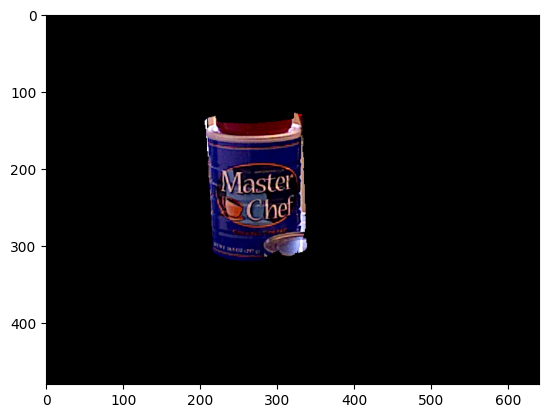

In [56]:
video = condorgmm.data.YCBTestVideo(48)
frame = video[0]
mask = frame.masks[0]
plt.imshow(frame.rgb * mask[...,None])



In [70]:
object_mask = mask

importlib.reload(condorgmm.utils.common.pose)
importlib.reload(condorgmm.utils.common)
importlib.reload(condorgmm.utils)
importlib.reload(condorgmm)

importlib.reload(condorgmm.warp_gmm.gmm_warp)
importlib.reload(warp_gmm)

indices = np.random.choice(object_mask.sum(), size=3000, replace=False)


spatial_means = np.array(
    condorgmm.xyz_from_depth_image(frame.depth, *frame.intrinsics)[object_mask, :].reshape(-1,3),
    dtype=np.float32
)[indices, :]
object_pose = condorgmm.Pose.from_translation( np.median(spatial_means, axis=0))
spatial_means = object_pose.inv().apply(spatial_means).astype(np.float32)
rgb_means = np.array(frame.rgb[object_mask, :].reshape(-1, 3), dtype=np.float32)[indices, :]
log_rgb_scales = np.array(np.log(np.ones_like(rgb_means) * 4.0), dtype=np.float32)
mask_warp = wp.array(object_mask, dtype=wp.bool)
log_spatial_scales = np.array(np.log(np.ones_like(spatial_means) * 0.01), dtype=np.float32)

gmm =  warp_gmm.gmm_warp_from_numpy(
    spatial_means=spatial_means,
    rgb_means=rgb_means,
    log_rgb_scales=log_rgb_scales,
    log_spatial_scales=log_spatial_scales,
    object_posquats=object_pose.posquat[None,:]
)
warp_gmm_state = warp_gmm.initialize_state(gmm=gmm, frame=frame)
warp_gmm_state.hyperparams.window_half_width = 20
warp_gmm_state.mask = mask_warp


warp_gmm_state.gmm.spatial_means.requires_grad = True
warp_gmm_state.gmm.quaternions_imaginary.requires_grad = True
warp_gmm_state.gmm.quaternions_real.requires_grad = True
warp_gmm_state.gmm.rgb_means.requires_grad = True
warp_gmm_state.gmm.log_spatial_scales.requires_grad = True
frame_warp = frame.as_warp()

warp_gmm.optimize_params(
    [warp_gmm_state.gmm.spatial_means, warp_gmm_state.gmm.log_spatial_scales,
                      warp_gmm_state.gmm.rgb_means,
                      warp_gmm_state.gmm.quaternions_imaginary, warp_gmm_state.gmm.quaternions_real],
    frame_warp,
    warp_gmm_state,
    num_timesteps=200,
    lr=[5e-4, 5e-3, 1e-2, 1e-2,1e-2],
    use_tqdm = True
)
condorgmm.rr_init("scene_graph")
condorgmm.rr_set_time(0)
condorgmm.rr_log_frame(frame)
warp_gmm.rr_log_gmm_warp(warp_gmm_state.gmm, size_scalar=1.0)

condorgmm.rr_log_depth(warp_gmm_state.log_score_image.numpy())

Likelihood: -7584096.0:   0%|          | 0/200 [00:00<?, ?it/s]

Likelihood: -7535286.5: 100%|██████████| 200/200 [00:06<00:00, 29.35it/s]


In [69]:
warp_gmm.rr_log_gmm_warp(warp_gmm_state.gmm, size_scalar=1.5)
